# MLFlow for Kaggle I - Loan Approval Prediction

In this notebook we will use the Loan Approval dataset to demonstrate how to build a machine learning pipeline using the MLFlow library. We will use the following steps:

1. Data Collection
2. Data Preprocessing
3. Train, Test, Validation Split
4. Model Training
5. Model Evaluation
6. Model Tracking
7. Kaggle Submission
8. BONUS: Exercises

## 1. Data Collection

### Loan Approval Prediction

We are going to take the data form kaggle, so we need to install the kaggle library and download the data. Here is the link to the Loan Approval Prediction: https://www.kaggle.com/competitions/playground-series-s4e10/overview. In order to start this competition we need to **manually join the competition** to accept the terms and conditions.

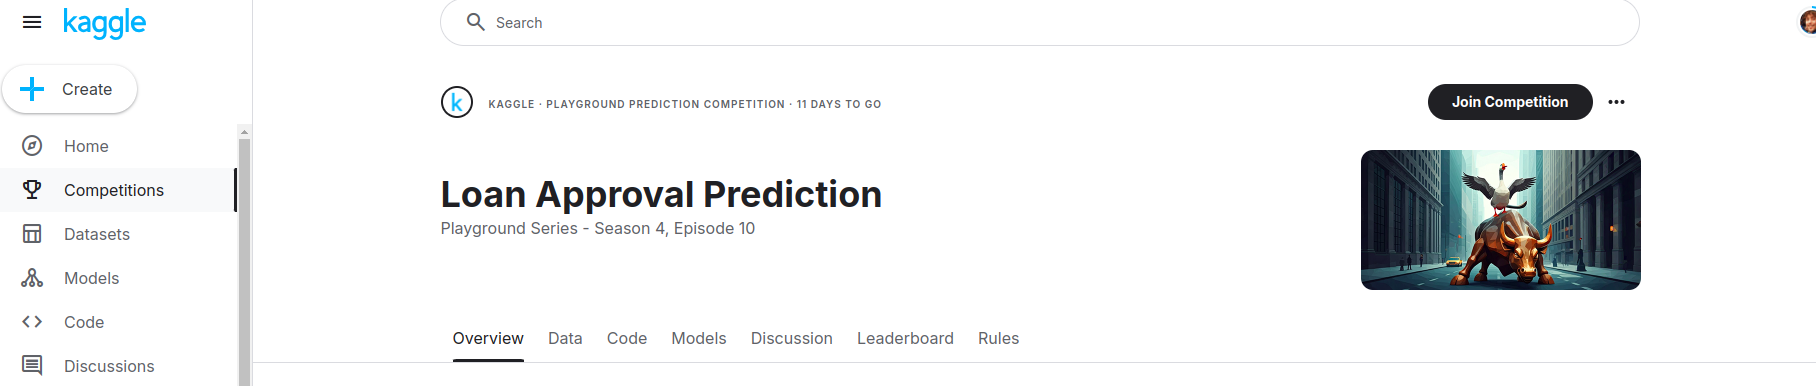

We then need to get an API TOKEN from kaggle. To do this we need to go to the kaggle website, click on the profile icon and then click on "My Account". In the "API" section we can click on "Create New API Token" to download the token. We then need to move the token to the `~/.kaggle` folder and rename it to `kaggle.json`.

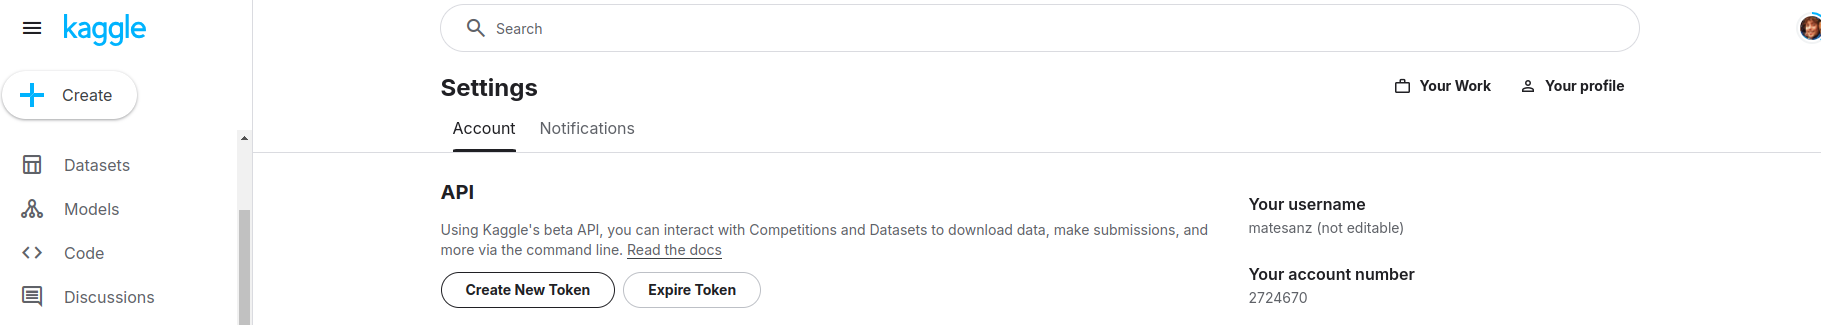

Once we've join the competition we can download the data using the following commands:

```bash
pip install kaggle
kaggle competitions download -c playground-series-s4e10
```

You also have the option to **download the data manually** by going to `Data` > `Download Data`

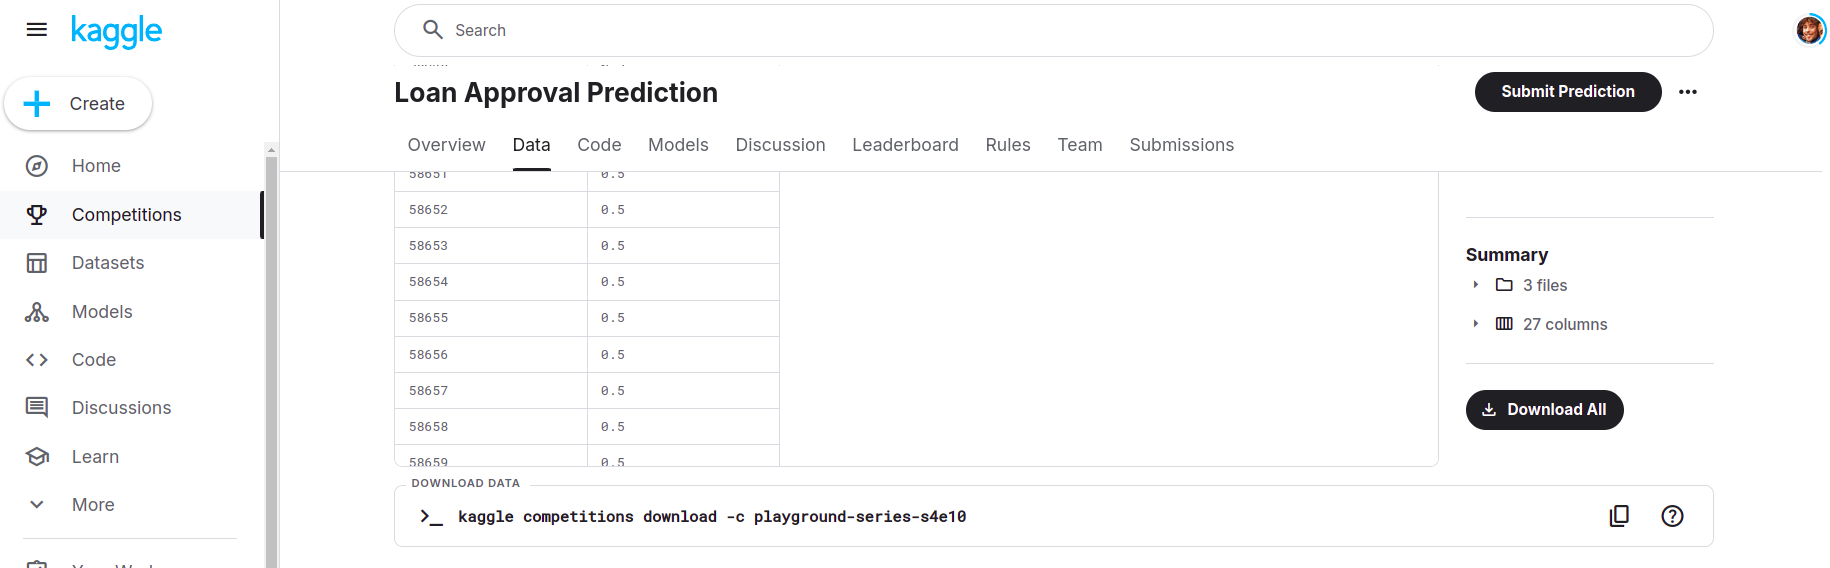

Once we've downloaded the data we are going to save it into `data/loan_prediciton`. We can see there are three files:

- `train.csv`: The training data
- `test.csv`: The test data
- `sample_submission.csv`: The sample submission file

ℹ️ Remember that `test.csv` does not have the target column, we will use it to evaluate our model against the kaggle platform.

### Explore the data

Let's load the data and take a look at the first few rows.

In [1]:
import pandas as pd


DATA_FOLDER = "../data/loan_prediction/"
TRAIN_CSV_PATH = DATA_FOLDER + "train.csv"
TEST_CSV_PATH = DATA_FOLDER + "test.csv"

train_df = pd.read_csv(TRAIN_CSV_PATH)
test_df = pd.read_csv(TEST_CSV_PATH)

data_df = pd.concat([train_df, test_df], keys=["train", "test"])
data_df.head()

id  person_age  person_income person_home_ownership  \
train 0   0          37          35000                  RENT   
      1   1          22          56000                   OWN   
      2   2          29          28800                   OWN   
      3   3          30          70000                  RENT   
      4   4          22          60000                  RENT   

         person_emp_length loan_intent loan_grade  loan_amnt  loan_int_rate  \
train 0                0.0   EDUCATION          B       6000          11.49   
      1                6.0     MEDICAL          C       4000          13.35   
      2                8.0    PERSONAL          A       6000           8.90   
      3               14.0     VENTURE          B      12000          11.11   
      4                2.0     MEDICAL          A       6000           6.92   

         loan_percent_income cb_person_default_on_file  \
train 0                 0.17                         N   
      1                 0.07                         N   
      2                 0.21                         N   
      3                 0.17                         N   
      4                 0.10                         N   

         cb_person_cred_hist_length  loan_status  
train 0                          14          0.0  
      1                           2          0.0  
      2                          10          0.0  
      3                           5          0.0  
      4                           3          0.0

In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 97743 entries, ('train', 0) to ('test', 39097)
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          97743 non-null  int64  
 1   person_age                  97743 non-null  int64  
 2   person_income               97743 non-null  int64  
 3   person_home_ownership       97743 non-null  object 
 4   person_emp_length           97743 non-null  float64
 5   loan_intent                 97743 non-null  object 
 6   loan_grade                  97743 non-null  object 
 7   loan_amnt                   97743 non-null  int64  
 8   loan_int_rate               97743 non-null  float64
 9   loan_percent_income         97743 non-null  float64
 10  cb_person_default_on_file   97743 non-null  object 
 11  cb_person_cred_hist_length  97743 non-null  int64  
 12  loan_status                 58645 non-null  float64
dtypes: float64

In [ ]:
train_df.isna().sum()

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

## 2. Data Preprocessing

Remember that we need to preprocess the data before training the model. We will do the following steps:

### Encode Categorical Variables

As an example we will use the `LabelEncoder` to encode the `object` columns.

In [4]:
from sklearn.preprocessing import LabelEncoder


encoded_df = data_df.copy()
cat_columns = data_df.select_dtypes(include=["object"]).columns
for col in cat_columns:
    le = LabelEncoder()
    encoded_df[col] = le.fit_transform(data_df[col])

encoded_df.head()

id  person_age  person_income  person_home_ownership  \
train 0   0          37          35000                      3   
      1   1          22          56000                      2   
      2   2          29          28800                      2   
      3   3          30          70000                      3   
      4   4          22          60000                      3   

         person_emp_length  loan_intent  loan_grade  loan_amnt  loan_int_rate  \
train 0                0.0            1           1       6000          11.49   
      1                6.0            3           2       4000          13.35   
      2                8.0            4           0       6000           8.90   
      3               14.0            5           1      12000          11.11   
      4                2.0            3           0       6000           6.92   

         loan_percent_income  cb_person_default_on_file  \
train 0                 0.17                          0   
      1                 0.07                          0   
      2                 0.21                          0   
      3                 0.17                          0   
      4                 0.10                          0   

         cb_person_cred_hist_length  loan_status  
train 0                          14          0.0  
      1                           2          0.0  
      2                          10          0.0  
      3                           5          0.0  
      4                           3          0.0

### Data Correlation

Let's take a look at the correlation between the features and the target variable

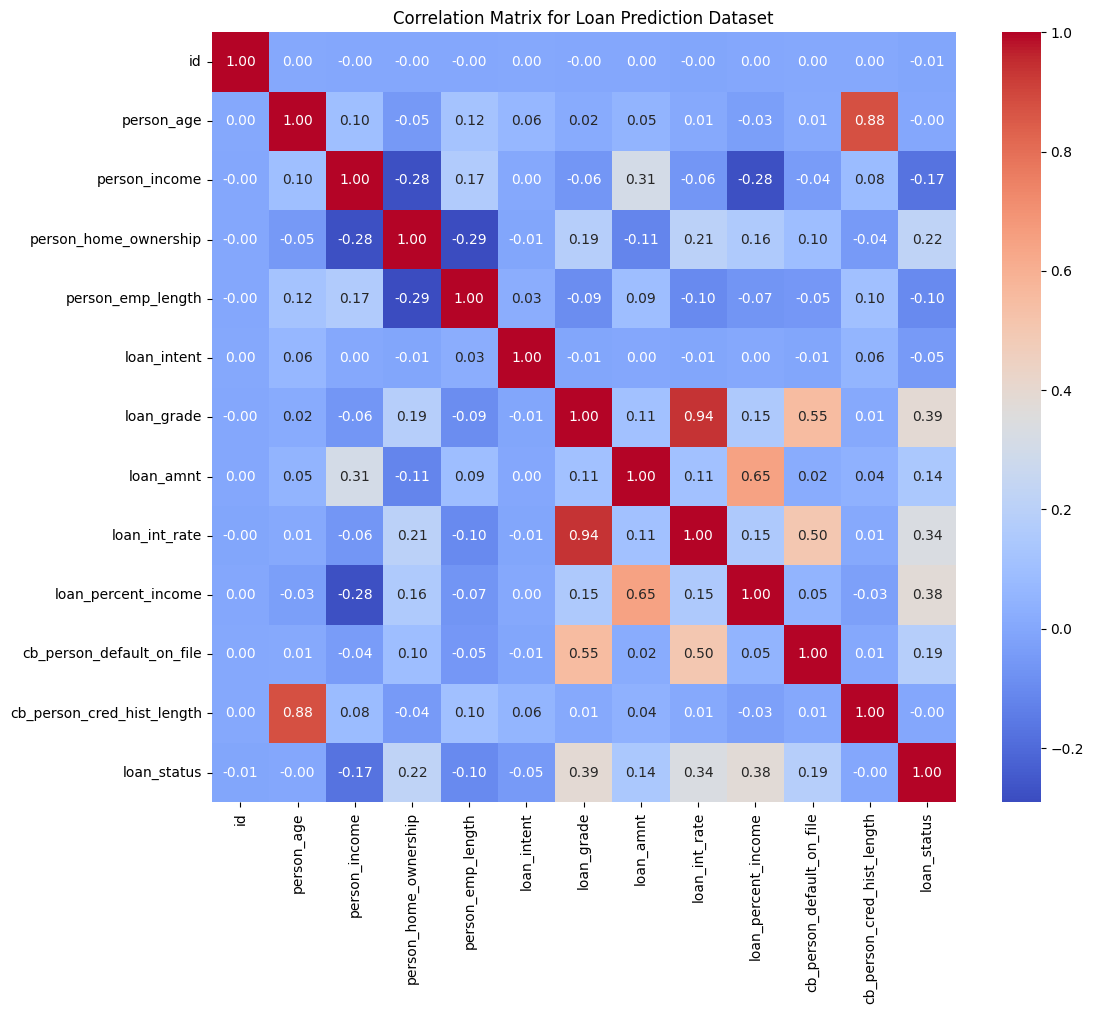

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt


CORRELATION_IMAGE_PATH = DATA_FOLDER + "correlation_matrix.png"

# plot the correlation matrix
corr = encoded_df.corr()
fig = plt.figure(figsize=(12, 10))
ax = sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
ax.set_title("Correlation Matrix for Loan Prediction Dataset")

# save the image to upload it to mlflow as an artifact
plt.savefig(CORRELATION_IMAGE_PATH)

## 3. Train, Test, Validation split

We now split the the dataframe into training and validation sets. We will use the training set to train the model and the validation set to evaluate the model. Finally, we will use the test set to generate the predictions and send them to the kaggle platform.

In [6]:
from sklearn.model_selection import train_test_split


TEST_SIZE = 0.2
RANDOM_STATE = 42

train_df = encoded_df.loc["train"]


X = train_df.drop(columns=["loan_status"])
y = train_df["loan_status"]


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## 4. Model Training

Once we have preprocessed the data we can train the model.

In [7]:
from sklearn.ensemble import RandomForestClassifier


model = RandomForestClassifier(random_state=RANDOM_STATE)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## 5. Model Evaluation

This competition uses the **Area Under the Curve (AUC)** as the evaluation metric.

In [8]:
from sklearn.metrics import roc_auc_score


y_val_pred = model.predict(X_val)
auc = roc_auc_score(y_val, y_val_pred)
print(f"Validation AUC: {auc:.4f}")

Validation AUC: 0.8450


### Generate submission file

Looking at the `submission_sample.csv` file we see that it hmut have two columns: `id` and `loan_status`. The `id` column must have the same values as the test set and the `loan_status` column must have the predictions.

In [9]:
# Save the CSV to be submitted to a file
SUBMISSION_CSV_PATH = DATA_FOLDER + 'submission.csv'

# get the input data of the test set
test_df = encoded_df.loc["test"]
test_df = test_df.drop(columns=["loan_status"])

# obtain the predictions
y_test_pred = model.predict(test_df)

# prepare the data to be submitted
ids_column = test_df["id"]
submission_data = {
    "id": ids_column,
    "loan_status": y_test_pred
}

# save it to a CSV file
submission_df = pd.DataFrame(submission_data)
submission_df.to_csv(SUBMISSION_CSV_PATH, index=False)
submission_df.head()

,id,loan_status
0,58645,1.0
1,58646,0.0
2,58647,1.0
3,58648,0.0
4,58649,0.0


## 6. Model Tracking

Once we have trained the model we can use the MLFlow library to track the model performance. We can log the AUC, the metrics, the submission file...

### Connect to MLFlow

In [10]:
import mlflow


MLFLOW_TRACKING_URI = "http://localhost:5000" 

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("loan_prediction")

<Experiment: artifact_location='mlflow-artifacts:/520808016506971461', creation_time=1729622595624, experiment_id='520808016506971461', last_update_time=1729622595624, lifecycle_stage='active', name='loan_prediction', tags={}>

### Submit to MLFlow

In [12]:
with mlflow.start_run():

    # log a tag to identify the model
    mlflow.set_tag("model", "RandomForestClassifier")

    # log the evaluation metric
    mlflow.log_metric("auc", auc)

    # log the correlation matrix image and the submission CSV
    mlflow.log_artifact(CORRELATION_IMAGE_PATH)
    mlflow.log_artifact(SUBMISSION_CSV_PATH)

    # log the model itself
    mlflow.sklearn.log_model(model, "my_logged_model")

2024/10/22 19:20:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/22 19:20:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run bright-newt-398 at: http://localhost:5000/#/experiments/520808016506971461/runs/9fd80833837146bba7e61fa25d0f38aa.
2024/10/22 19:20:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/520808016506971461.


## 7. Kaggle Submission

Finally we can submit the predictions to the kaggle platfrom. To do so we are going to retrieve the submission CSV from the best MLFlow run and submit it to the kaggle platform.

### Get the best run

In [56]:
runs = mlflow.search_runs(order_by=['metrics.auc DESC'])
best_run_id = runs.iloc[0]["run_id"]
best_run_name = runs.iloc[0]["tags.mlflow.runName"]
f"Best run: {best_run_name} (run_id: {best_run_id})"

'Best run: marvelous-moth-150 (run_id: c9049224e2644dae921a91ffecf4ac9f)'

### Download the submission file

In [57]:
from pathlib import Path
from mlflow import MlflowClient


client = MlflowClient()
submission_filename = Path(SUBMISSION_CSV_PATH).name
submision_csv_path = client.download_artifacts(best_run_id, submission_filename, DATA_FOLDER)

### Submit to Kaggle

You could upload the results manually by going to the kaggle website and clicking on `Submit Predictions`. You can then upload the file and submit it. Or you can use the kaggle API to submit the file:

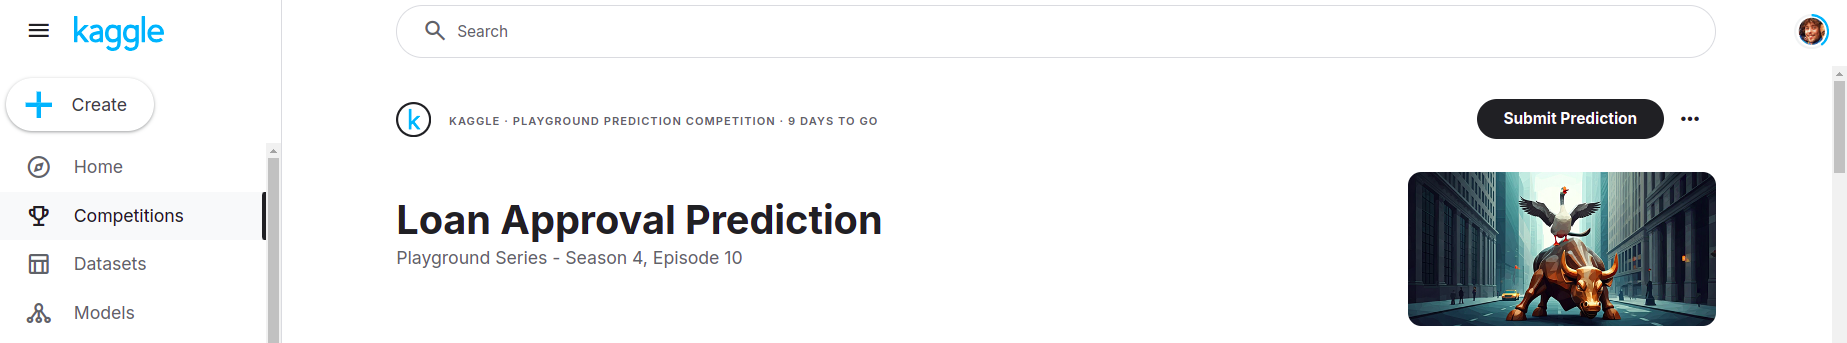

In [58]:
import kaggle


competition = "playground-series-s4e10"
message = f"Loan Prediction for run ID {best_run_name}"
kaggle.api.competition_submit(submision_csv_path, message, competition)

100%|██████████| 382k/382k [00:00<00:00, 498kB/s]


Successfully submitted to Loan Approval Prediction

### 🎉 My Submission!:

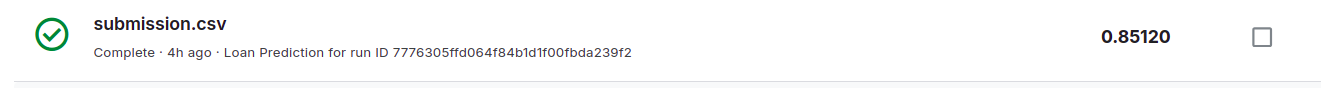

## Bonus: Exercises

Now improve this notebook by doing the following exercises:

1. Log the Correlation Heatmap to MLflow

2. Model Tracking: log the model parameters to MLFlow

3. Model Training: try another model from the `sklearn` library log the results and compare them in MLFLow


4. Model Training: try another models from other libraries like `xgboost`, `lightgbm`, `catboost`... and compare the results


5. Model Evaluation: try another metrics (which metrics should we use for a classification problem?) and log them to MLFlow

6. Think about the train-test-validation split. How can we improve our model generalization? 


7. Model Evaluation: Think about the evaluation we are doing. Is it correct? How can we improve it?

8. Take a look into the [Kaggle Code Section](https://www.kaggle.com/competitions/playground-series-s4e10/code), did you find any interesting notebooks? Optional: Try to implement some of the ideas in this notebook.

9. Optional: Upload this notebook to the [Code Section of this Kaggle competition](https://www.kaggle.com/competitions/playground-series-s4e10/code) (show a picture of the notebook in the comments)